In [2]:
import os
import glob as glob

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np

import nibabel as nib
from nilearn import image, plotting
from nilearn.plotting import plot_stat_map, plot_anat, plot_img
from nilearn.image import load_img, new_img_like
from nilearn.input_data import NiftiMasker
from nilearn import datasets, plotting, input_data, signal, image  
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import sym_matrix_to_vec, vec_to_sym_matrix

from scipy.stats import spearmanr, pearsonr



#plt.style.use('seaborn-white')
plt.rcParams['font.family'] = 'Helvetica'

small = 20
medium = 20
bigger = 20

plt.rc('font', size=small)          # controls default text sizes
plt.rc('axes', titlesize=small)     # fontsize of the axes title
plt.rc('axes', linewidth=2.2)
plt.rc('axes', labelsize=medium)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=small)    # fontsize of the tick labels
plt.rc('ytick', labelsize=small)    # fontsize of the tick labels
plt.rc('legend', fontsize=small)    # legend fontsize
plt.rc('figure', titlesize=bigger)  # fontsize of the figure title
plt.rc('lines', linewidth=2.2, color='gray')

#--- setup
rdms_dir = f'/home/finc/1stlevel_surveyMedley/'  #'/oak/stanford/groups/russpold/data/uh2/BIDS_data/derivatives/surveyMedley/1stlevel_surveyMedley/'
beh_dir = '/home/finc/Dropbox/Projects/SelfReg/data/behavioral/'
#loading Schaefer atlas (400 regions)
n_rois = 400

subs_list = np.sort(os.listdir(rdms_dir))
subs_list = [i for i in subs_list if len(i) == 8]

parcellation = 'shaefer_400_7'
n_trials = 40

len(subs_list)

67

Step 1: Loading similarity matrices
--------------------------------------

In [3]:
i = 0
rdms = np.zeros((67,400,40,40))

for i, sub in enumerate(subs_list):
    path = f'{rdms_dir}{sub}/{sub}_shaefer_400_7_corr.npy'
    if not os.path.exists(path):
        continue
        
    else:
        rdms[i,:,:,:] = np.load(path)
        i += 1
rdms.shape


mean_rdms = rdms.mean(axis=0)
vector_nan = [False if sum(sum(np.isnan(elem))) > 0 else True for elem in mean_rdms] 

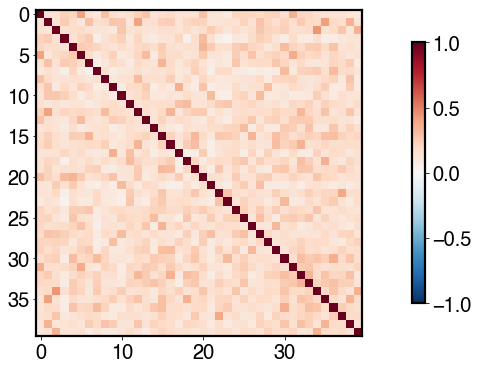

In [4]:
plotting.plot_matrix(mean_rdms[70,:,:], vmin = -1, vmax = 1)

Step 1: Loading similarity matrices (with vectorization)
--------------------------------------

In [5]:
i = 0
rdms = np.zeros((67,400,780))

for i, sub in enumerate(subs_list):
    path = f'{rdms_dir}{sub}/{sub}_shaefer_400_7_corr.npy'
    if not os.path.exists(path):
        continue
        
    else:
        rdm = np.load(path)
        rdms[i,:,:] = np.arctanh(sym_matrix_to_vec(rdm, discard_diagonal = True))
        i += 1
rdms.shape

mean_rdms = rdms.mean(axis=0)

/home/finc/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in arctanh
  # This is added back by InteractiveShellApp.init_path()
/home/finc/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


Step 2: Loading behavioral matrices
--------------------------------------

In [9]:
beh_matrix_fmri = np.asarray(pd.read_csv(f'{beh_dir}behavioral_correlation_fmri.csv'))
beh_matrix_mturk = np.asarray(pd.read_csv(f'{beh_dir}behavioral_correlation_mturk.csv'))

beh_vector_fmri = sym_matrix_to_vec(beh_matrix_fmri, discard_diagonal = True)
beh_vector_mturk = sym_matrix_to_vec(beh_matrix_mturk, discard_diagonal = True)
beh_vector_fmri.shape

(780,)

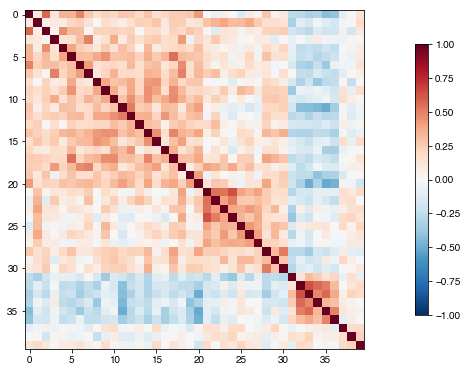

In [6]:
plotting.plot_matrix(beh_matrix_fmri, vmin = -1, vmax = 1)

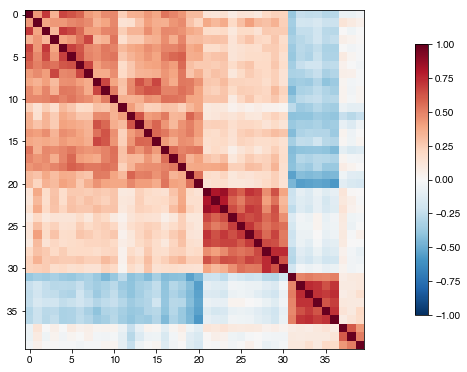

In [9]:
plotting.plot_matrix(beh_matrix_mturk, vmin = -1, vmax = 1)

In [6]:
mean_rdms_clean = mean_rdms[vector_nan, :]
mean_rdms_clean.shape

(368, 780)

Step 3: Plotting correlation between behavioral vectors
--------------------------------------

/home/finc/anaconda/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


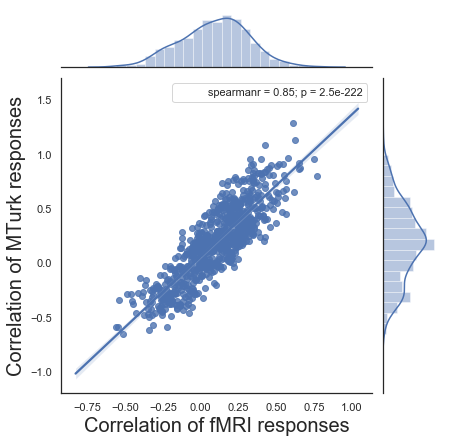

In [10]:
import seaborn as sns
import seaborn as sns; sns.set(style="white", color_codes=True)

j = sns.jointplot(x = np.arctanh(beh_vector_fmri), y = np.arctanh(beh_vector_mturk), kind="reg")
j.annotate(spearmanr)
j.set_axis_labels('Correlation of fMRI responses', 'Correlation of MTurk responses', fontsize=20)


Step 4: Creating one array with all representational similarity and behavioral vectors
--------------------------------------

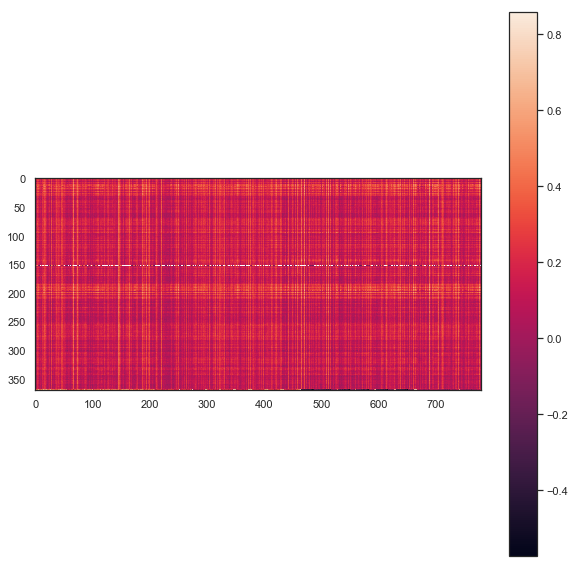

In [16]:
mean_rdms_clean.shape
vectorized = mean_rdms_clean
vectorized.shape

vectorized_all = np.zeros((370, 780))
vectorized_all[0:368,:] = vectorized
vectorized_all[368,:] = beh_vector_fmri
vectorized_all[369,:] = beh_vector_mturk
vectorized_all.shape

plt.figure(figsize=(10, 10))
plt.imshow(vectorized_all)
plt.colorbar()

Step 5: Calculating correlations
--------------------------------------

In [17]:
cor_spear = spearmanr(np.arctanh(vectorized_all.T))
cor_pear = np.corrcoef(np.arctanh(vectorized_all))

/home/finc/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in arctanh
  """Entry point for launching an IPython kernel.


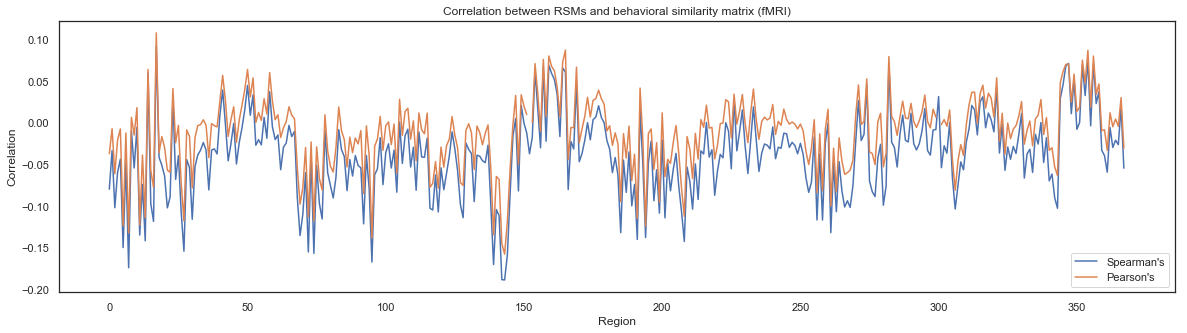

In [18]:
plt.figure(figsize=(20, 5))
plt.plot(cor_spear[0][368,0:368])
plt.plot(cor_pear[368,0:368])
plt.title('Correlation between RSMs and behavioral similarity matrix (fMRI)')
plt.xlabel('Region')
plt.ylabel('Correlation')
plt.legend(['Spearman\'s', 'Pearson\'s'])

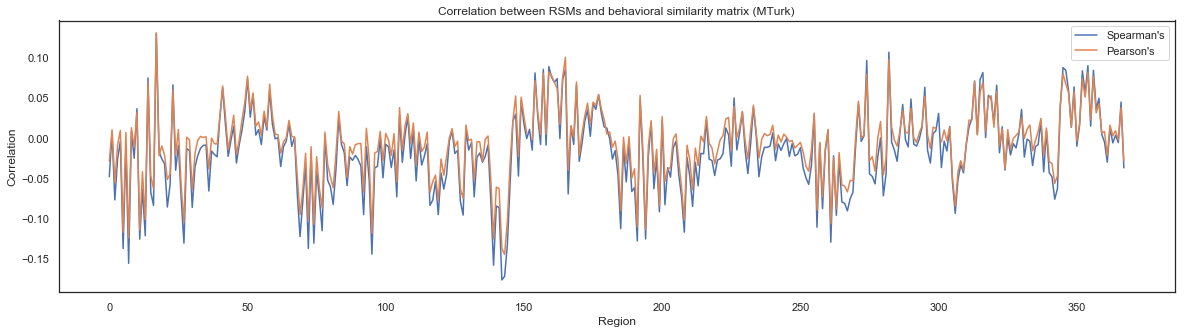

In [20]:
plt.figure(figsize=(20, 5))
plt.plot(cor_spear[0][369,0:368])
plt.plot(cor_pear[369,0:368])
plt.title('Correlation between RSMs and behavioral similarity matrix (MTurk)')
plt.xlabel('Region')
plt.ylabel('Correlation')
plt.legend(['Spearman\'s', 'Pearson\'s'])

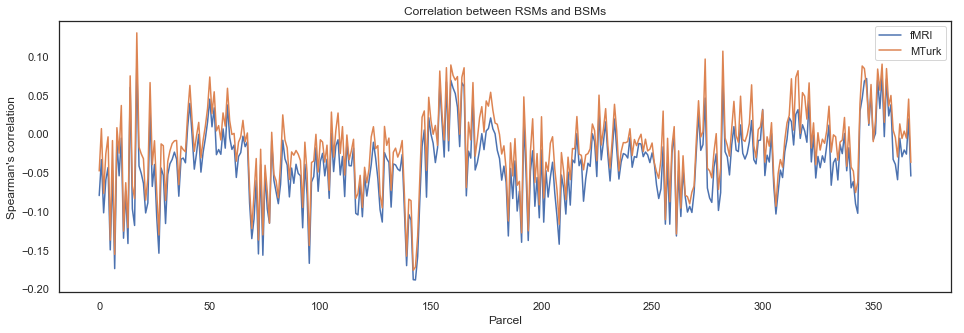

In [19]:
plt.figure(figsize=(16, 5))
plt.plot(cor_spear[0][368,0:368])
plt.plot(cor_spear[0][369,0:368])
#plt.plot(cor_pear[369,0:368])
plt.title('Correlation between RSMs and BSMs')
plt.xlabel('Parcel')
plt.ylabel('Spearman\'s correlation')
plt.legend(['fMRI', 'MTurk'])

Step 6: Correlations betwen RDMs across brain regions
--------------------------------------

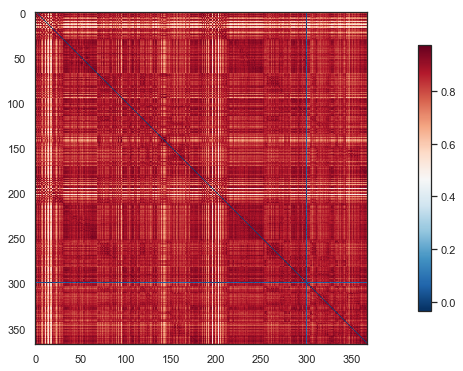

In [22]:
corr = cor_spear[0][0:368,0:368]
np.fill_diagonal(corr, 0)

plotting.plot_matrix(corr, cmap="RdBu_r")

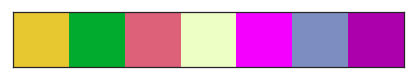

In [25]:
labels = pd.read_csv('/home/finc/Dropbox/Projects/SelfReg/support/Schaefer2018_400Parcels_7Networks.csv', header = None)
labels = labels[0].values
labels_raw = labels 
schaefer7 = {'CON':'#e8c830',
                'DAN':'#00ab2e', 
                'DM':'#dc6179', 
                'LIM':'#eeffc5', 
                'SAL':'#f300ff',
                'SOM':'#7e8dc1', 
                'VIS':'#ac00ad',}

pallette = schaefer7

network_pal = (sns.color_palette(pallette.values()))
sns.palplot(sns.color_palette(pallette.values()))

labels = labels[vector_nan]
idx = np.argsort(labels)
sorted_labels = labels[idx]

network_lut = dict(zip(map(str, np.unique(sorted_labels)), network_pal))

network_colors = pd.Series(sorted_labels).map(network_lut)
network_colors = np.asarray(network_colors)

Text(0.5, 1.0, "Histogram: Spearman's correlation distribution")

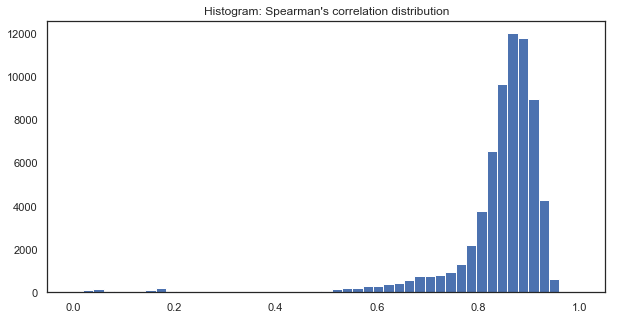

In [26]:
plt.figure(figsize=(10, 5))

corr_vec = sym_matrix_to_vec(corr, discard_diagonal=True)
plt.hist(corr_vec, bins = np.linspace(0,1))
plt.title('Histogram: Spearman\'s correlation distribution')

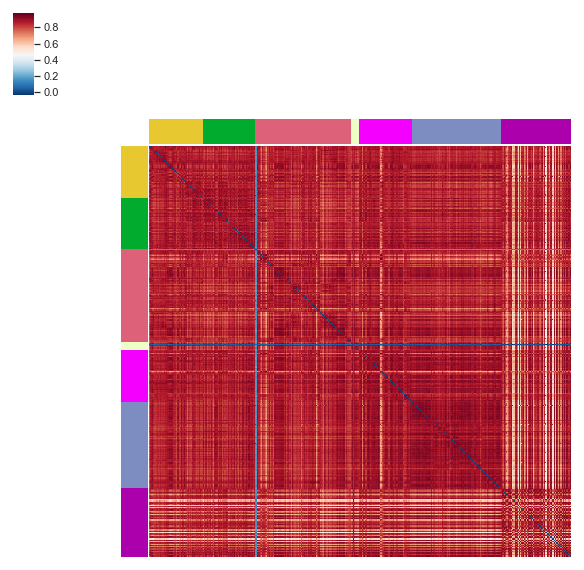

In [28]:
cor_ord = corr[:,idx]
cor_ord = cor_ord[idx,:]

g = sns.clustermap(cor_ord,
                   cmap="RdBu_r",
                   row_cluster=False,
                   col_cluster=False,
                   row_colors=network_colors,
                   col_colors=network_colors,
                   linewidths=0,
                   yticklabels=False,
                   xticklabels=False)

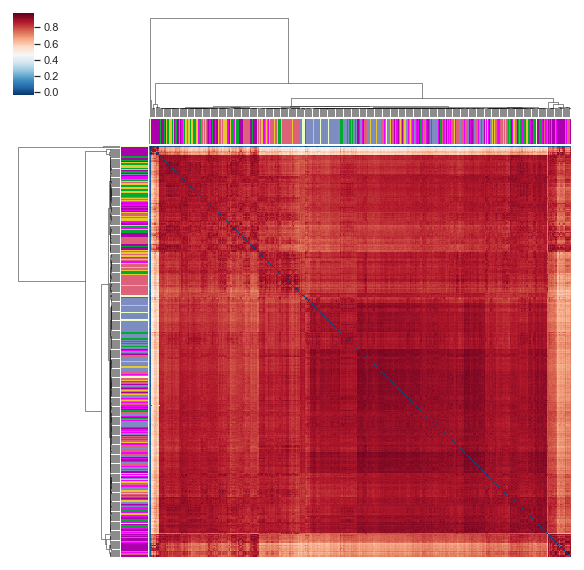

In [30]:
g = sns.clustermap(cor_ord,
                   cmap="RdBu_r",
                   row_cluster=True,
                   col_cluster=True,
                   row_colors=network_colors,
                   col_colors=network_colors,
                   linewidths=0,
                   yticklabels=False,
                   xticklabels=False)

In [32]:
table = pd.DataFrame()
labels_clean = labels_raw[vector_nan]
cor_spear_vector_fmri = cor_spear[0][368,0:368]
cor_spear_vector_mturk = cor_spear[0][369,0:368]

for i in range(len(labels_clean)):
    table_temp = pd.DataFrame({'Network':labels_clean[i], 
                               'Spearman_corr_fmri': cor_spear_vector_fmri[i], 
                               'Spearman_corr_mturk': cor_spear_vector_mturk[i],
                              # 'Correlarion_Pearson': cor_pear_vector[i]
                              }, 
                              index = [0])
    
    
    table = pd.concat([table, table_temp])

In [41]:
#plt.style.use('seaborn-white')
plt.rcParams['font.family'] = 'Helvetica'

small = 20
medium = 20
bigger = 20

plt.rc('font', size=small)          # controls default text sizes
plt.rc('axes', titlesize=small)     # fontsize of the axes title
plt.rc('axes', linewidth=2.2)
plt.rc('axes', labelsize=medium)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=small)    # fontsize of the tick labels
plt.rc('ytick', labelsize=small)    # fontsize of the tick labels
plt.rc('legend', fontsize=small)    # legend fontsize
plt.rc('figure', titlesize=bigger)  # fontsize of the figure title
plt.rc('lines', linewidth=2.2, color='gray')

(-0.1, 0.1)

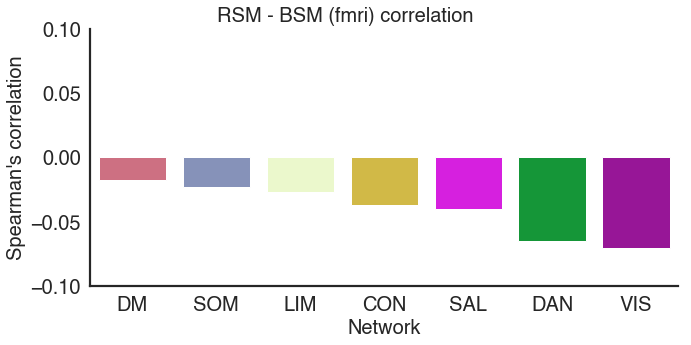

In [42]:
summary = table.groupby('Network').mean()
summary['Network'] = summary.index

results = summary.sort_values('Spearman_corr_fmri', ascending = False)

g = sns.catplot(y = 'Spearman_corr_fmri', x = 'Network', data = results, kind = 'bar', aspect = 2, order = results['Network'], palette = schaefer7)
g.set_axis_labels(y_var="Spearman\'s correlation")
g.fig.suptitle('RSM - BSM (fmri) correlation')
plt.ylim(-0.1, 0.1)

(-0.1, 0.1)

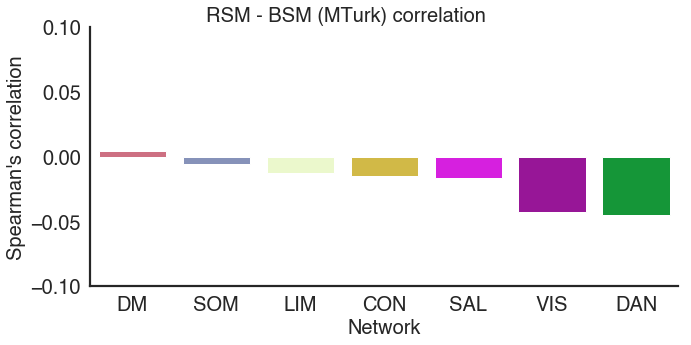

In [44]:
results = summary.sort_values('Spearman_corr_mturk', ascending = False)

g = sns.catplot(y = 'Spearman_corr_mturk', x = 'Network', data = results, kind = 'bar', aspect = 2, order = results['Network'], palette = schaefer7)
g.set_axis_labels(y_var="Spearman\'s correlation")
g.fig.suptitle('RSM - BSM (MTurk) correlation')
plt.ylim(-0.1, 0.1)


/home/finc/anaconda/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


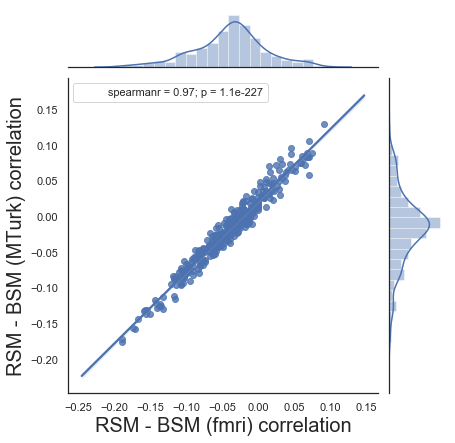

In [46]:
sns.set(style="white", color_codes=True)

j = sns.jointplot(x = cor_spear[0][368,0:368], y = cor_spear[0][369,0:368], kind="reg")
j.annotate(spearmanr)
j.set_axis_labels('RSM - BSM (fmri) correlation', 'RSM - BSM (MTurk) correlation', fontsize=20)
